Dataset Shape: (72139, 2)
    sentiment                                            comment
0    Positive  This looks like a poster for a 90s action movi...
1  Irrelevant  How Abhijeet Bhayya ur efforts are incredible ...
2     Neutral  Transvaginal mesh: Johnson & Johnson fined $34...
3    Negative  Why would this fortnite college hockey season ...
4    Positive  I actually quite like the design of the ps5. I...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/57711 [00:00<?, ? examples/s]

Map:   0%|          | 0/14428 [00:00<?, ? examples/s]

C:\Users\souvi\AppData\Local\Temp\ipykernel_4012\1243449088.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.488500,0.474571,0.831993,0.831433
2,0.189800,0.390130,0.898808,0.898658
3,0.363200,0.367274,0.916967,0.916976


Evaluation results: {'eval_loss': 0.3672739565372467, 'eval_accuracy': 0.9169670085943997, 'eval_f1': 0.9169759922382981, 'eval_runtime': 80.1978, 'eval_samples_per_second': 179.905, 'eval_steps_per_second': 22.494, 'epoch': 3.0}
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.92      0.89      0.91      2514
    Negative       0.93      0.92      0.93      4372
     Neutral       0.91      0.92      0.91      3528
    Positive       0.91      0.92      0.91      4014

    accuracy                           0.92     14428
   macro avg       0.92      0.91      0.92     14428
weighted avg       0.92      0.92      0.92     14428



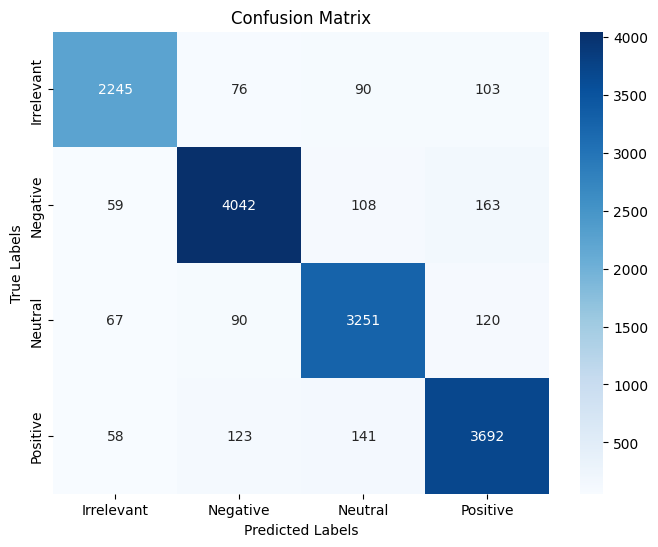

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("twitter-sentiment/sentiment-dataset.csv")
print("Dataset Shape:", df.shape)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Extract features and labels
X = df['comment']
y = df['sentiment']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [2]:
save_path = "./bert-ft"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.
